# Preprocessing All of the Samples and Storing the Sounds as Numerical Data

In [2]:
import os
from scipy.io import wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd

def list_samples_from_directory (sample_dir, include_dir_path) :
    '''
        list file names from directory that end in .wav
        either include or exclude directory path (probably always use true)
    '''
    if include_dir_path:
        sound_files = [sample_dir + file for file in os.listdir(sample_dir) if ".wav" in file and ".asd" not in file]
    else :
        sound_files = [file for file in os.listdir(sample_dir) if ".wav" in file]
    return sound_files

def split_whole_wav_to_individual_samples (sample_path, shortened_samples_destination, 
                                           desired_sample_time, time_between_samples) :
    '''
        Splits long sound samples into shorter samples taking into account spacing between the sounds
        Writes them to new files
        
        TODO: write data to a data file
    '''
    sample_rate, sample = wavfile.read(sample_path)

    sample_length = convert_sec_to_index(sample_rate, desired_sample_time)
    split_length = convert_sec_to_index(sample_rate, time_between_samples)
    
    individual_samples = [sample[i : i + sample_length] for i in range (0, len(sample), sample_length + split_length)]
    counter = 0
    for i in individual_samples :
        wavfile.write(shortened_samples_destination + str(counter)+".wav", sample_rate, i)
        counter += 1
    
def convert_sec_to_index (sampleRate, time):
    return int(time * sampleRate)


'''
    Process the samples
''' 
def plot_fft (snd, sampFreq, title, xlim):
    '''
        Takes sound arrays and sample frequencies from wavfile.read...
        
        Purpose is to let you perform fft on smaller pieces of sample.
    '''    
    X = fft(snd)
    freqs = np.fft.fftfreq(len(snd)) * sampFreq
    X = np.abs(X)/len(snd)
    X = X/max(X)
    
    fig, ax = plt.subplots()
    plt.ylabel("Normalized Amplitude")
    plt.xlabel("Frequency: Hz")
    plt.title(title)
    ax.plot(freqs, X)
    ax.set_xlim(0, xlim)
    plt.savefig(title +"_"+str(xlim)+".png")
    plt.show()
    
        

def perform_fft (snd, sampFreq):
    '''
        Takes sound arrays and sample frequencies from wavfile.read...
        
        Purpose is to let you perform fft on smaller pieces of sample.
    '''    
    X = fft(snd)
    freqs = np.fft.fftfreq(len(snd)) * sampFreq

    X = np.abs(X)/len(snd)
    X = X/max(X)
    
    return X, freqs

def convert_hz_to_index_in_fft(freq_spacing, freq, maxfreq):
    if freq > maxfreq :
        return maxfreq // freq_spacing
    else:
        return freq // freq_spacing

def extract_feature_vector (normalized_fft, classlabel):
    feature_vector = {}
    curr_freq_bin = 16.35
    feature_vector['class'] = classlabel
    for i in range (1, 12):
        curr_freq_bin_max = curr_freq_bin * 2
        
        bin_min_index = int (convert_hz_to_index_in_fft(10, curr_freq_bin, 22040))
        bin_max_index = int (convert_hz_to_index_in_fft(10, curr_freq_bin_max, 22040))
        
        feature_vector[str(i-1)] = \
            max(normalized_fft[int(bin_min_index) : int(bin_max_index)])
        
        curr_freq_bin = curr_freq_bin_max
    return feature_vector

def extract_feature_vector_hundred (normalized_fft, classlabel) :
    feature_vector = {}
    curr_freq_bin = 0
    feature_vector['class'] = classlabel
    for i in range (0, 11):
        curr_freq_bin_max = curr_freq_bin +100
        
        bin_min_index = int (convert_hz_to_index_in_fft(10, curr_freq_bin, 22040))
        bin_max_index = int (convert_hz_to_index_in_fft(10, curr_freq_bin_max, 22040))
        
        feature_vector[str(i)] = \
            max(normalized_fft[int(bin_min_index) : int(bin_max_index)])
        
        curr_freq_bin = curr_freq_bin_max
    return feature_vector

def process_sample_sets(locations_to_instruments, instrument_shortened_sample_locations, outputfilepath, start, end, length, shiftamnt, numshifts):
    '''
        locations to instruments is a dict of the locations to the names of the instruments
        the other should be self explanatory
    '''
    dataframe_columns = ['class'] + [str(i) for i in range (0,11)]
    df = pd.DataFrame(columns=dataframe_columns)

    ''' 
        Extract feature vectors from all of the samples (and split each sample
        into short 0.1 second samples for more data)
    '''
    print ("Extracting feature vectors... ")

    for instrument_location in instrument_shortened_sample_locations :
        samples = list_samples_from_directory(instrument_location, True)
        for sample in samples :
            for curshift in range(0,numshifts + 1): 
                for kuk in frange (start + curshift*shiftamnt, end + curshift*shiftamnt, length):
                    samplingFrequency, fuckme = wavfile.read(sample)
                    xfft, fff = perform_fft(fuckme[convert_sec_to_index(samplingFrequency, kuk): convert_sec_to_index(samplingFrequency, kuk+length)], samplingFrequency)
                    har = extract_feature_vector(xfft, locations_to_instrument[instrument_location])
                    df = df.append(har, ignore_index=True)
    
    df.to_csv(outputfilepath, index = False)
    
    

## Fourier Transform Plots for Visual Comparison

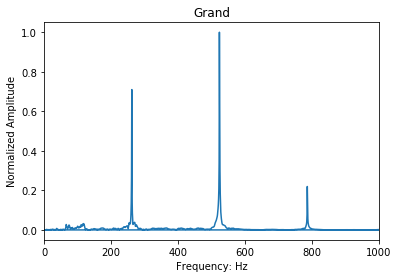

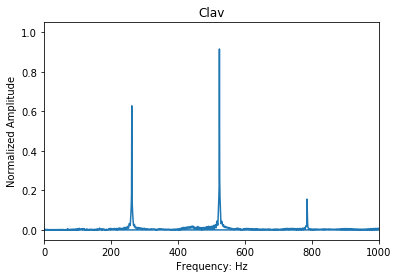

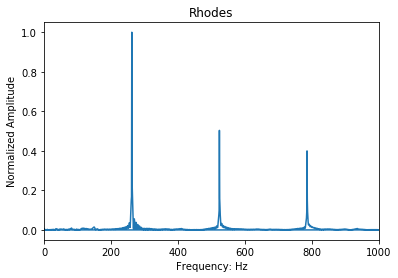

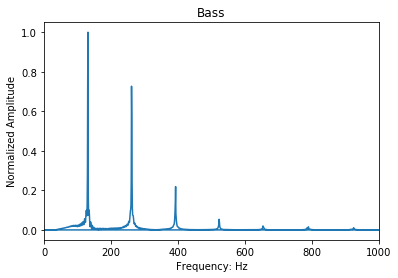

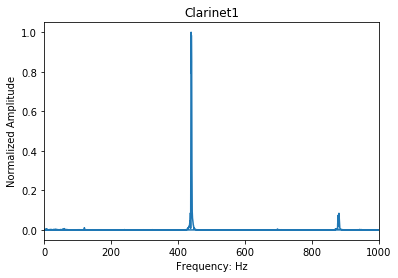

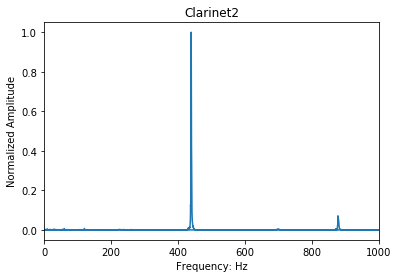

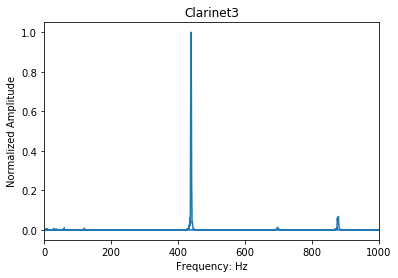

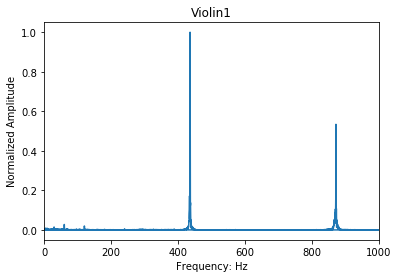

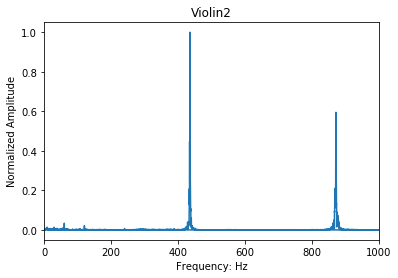

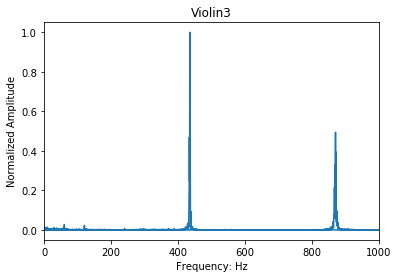

In [65]:
grandPianoSampleForPlot = "./Samples/Grand/Shortened/0.wav"
samplingFrequency, snd = wavfile.read(grandPianoSampleForPlot)
plot_fft(snd, samplingFrequency, "Grand", 1000)

clavSampleForPlot = "./Samples/Clav/Shortened/0.wav"
samplingFrequency, snd = wavfile.read(clavSampleForPlot)
plot_fft(snd, samplingFrequency, "Clav", 1000)


rhodesSampleForPlot = "./Samples/Rhodes/Shortened/0.wav"
samplingFrequency, snd = wavfile.read(rhodesSampleForPlot)
plot_fft(snd, samplingFrequency, "Rhodes", 1000)


bassSampleForPlot = "./Samples/Bass/Shortened/0.wav"
samplingFrequency, snd = wavfile.read(bassSampleForPlot)
plot_fft(snd, samplingFrequency, "Bass", 1000)

'''
    Clarinet Plots to show inconsistency
'''
clarinetSampleForPlot = "./Samples/Clarinet/Clarinet-A-1.wav"
samplingFrequency, snd = wavfile.read(clarinetSampleForPlot)
plot_fft(snd, samplingFrequency, "Clarinet1", 1000)

clarinetSampleForPlot = "./Samples/Clarinet/Clarinet-A-2.wav"
samplingFrequency, snd = wavfile.read(clarinetSampleForPlot)
plot_fft(snd, samplingFrequency, "Clarinet2", 1000)

clarinetSampleForPlot = "./Samples/Clarinet/Clarinet-A-3.wav"
samplingFrequency, snd = wavfile.read(clarinetSampleForPlot)
plot_fft(snd, samplingFrequency, "Clarinet3", 1000)



'''
    Violin Plots to show inconsistency
'''
violinSampleForPlot = "./Samples/Violin/Violin-A-1.wav"
samplingFrequency, snd = wavfile.read(violinSampleForPlot)
plot_fft(snd, samplingFrequency, "Violin1", 1000)

violinSampleForPlot = "./Samples/Violin/Violin-A-2.wav"
samplingFrequency, snd = wavfile.read(violinSampleForPlot)
plot_fft(snd, samplingFrequency, "Violin2", 1000)

violinSampleForPlot = "./Samples/Violin/Violin-A-3.wav"
samplingFrequency, snd = wavfile.read(violinSampleForPlot)
plot_fft(snd, samplingFrequency, "Violin3", 1000)

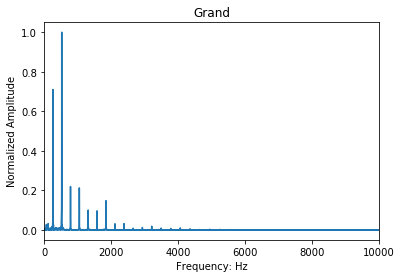

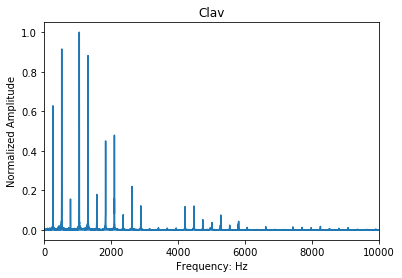

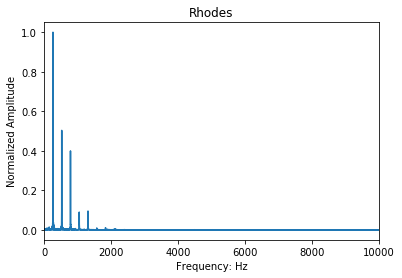

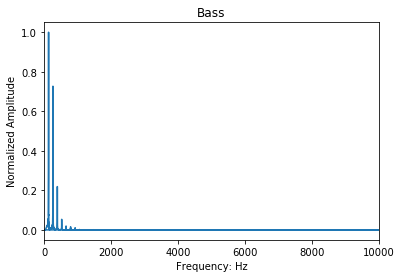

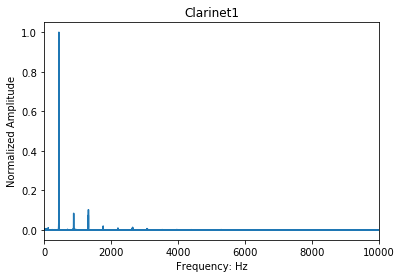

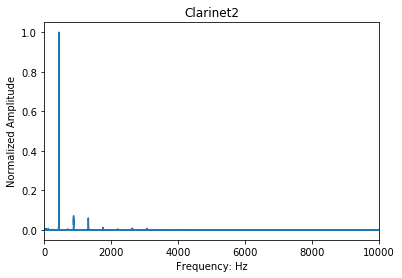

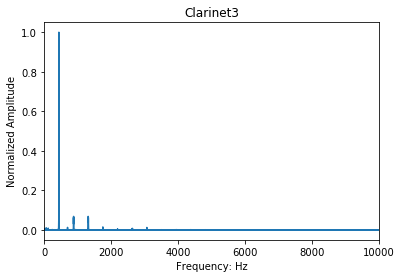

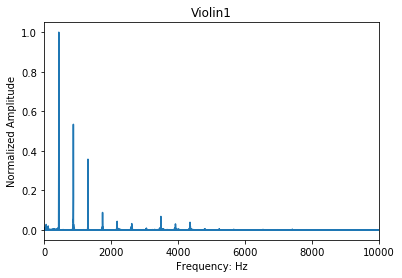

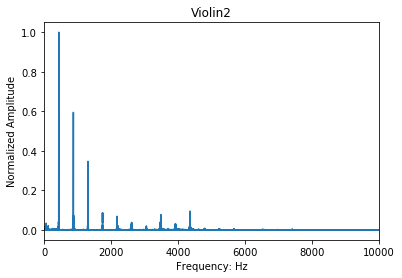

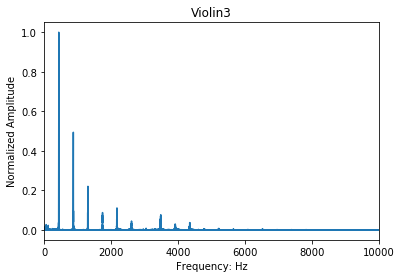

In [71]:
grandPianoSampleForPlot = "./Samples/Grand/Shortened/0.wav"
samplingFrequency, snd = wavfile.read(grandPianoSampleForPlot)
plot_fft(snd, samplingFrequency, "Grand", 10000)

clavSampleForPlot = "./Samples/Clav/Shortened/0.wav"
samplingFrequency, snd = wavfile.read(clavSampleForPlot)
plot_fft(snd, samplingFrequency, "Clav", 10000)


rhodesSampleForPlot = "./Samples/Rhodes/Shortened/0.wav"
samplingFrequency, snd = wavfile.read(rhodesSampleForPlot)
plot_fft(snd, samplingFrequency, "Rhodes", 10000)


bassSampleForPlot = "./Samples/Bass/Shortened/0.wav"
samplingFrequency, snd = wavfile.read(bassSampleForPlot)
plot_fft(snd, samplingFrequency, "Bass", 10000)

'''
    Clarinet Plots to show inconsistency
'''
clarinetSampleForPlot = "./Samples/Clarinet/Clarinet-A-1.wav"
samplingFrequency, snd = wavfile.read(clarinetSampleForPlot)
plot_fft(snd, samplingFrequency, "Clarinet1", 10000)

clarinetSampleForPlot = "./Samples/Clarinet/Clarinet-A-2.wav"
samplingFrequency, snd = wavfile.read(clarinetSampleForPlot)
plot_fft(snd, samplingFrequency, "Clarinet2", 10000)

clarinetSampleForPlot = "./Samples/Clarinet/Clarinet-A-3.wav"
samplingFrequency, snd = wavfile.read(clarinetSampleForPlot)
plot_fft(snd, samplingFrequency, "Clarinet3", 10000)



'''
    Violin Plots to show inconsistency
'''
violinSampleForPlot = "./Samples/Violin/Violin-A-1.wav"
samplingFrequency, snd = wavfile.read(violinSampleForPlot)
plot_fft(snd, samplingFrequency, "Violin1", 10000)

violinSampleForPlot = "./Samples/Violin/Violin-A-2.wav"
samplingFrequency, snd = wavfile.read(violinSampleForPlot)
plot_fft(snd, samplingFrequency, "Violin2", 10000)

violinSampleForPlot = "./Samples/Violin/Violin-A-3.wav"
samplingFrequency, snd = wavfile.read(violinSampleForPlot)
plot_fft(snd, samplingFrequency, "Violin3", 10000)

## Preprocess Samples and Record as Feature Vectors in CSV files

In [46]:
'''
    4 instruments
'''
instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Clav/Shortened/",
                                        "./Samples/Rhodes/Shortened/",
                                        "./Samples/Bass/Shortened/"
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Clav/Shortened/" : "Clav",
                            "./Samples/Rhodes/Shortened/" : "Rhodes",
                            "./Samples/Bass/Shortened/" : "Bass"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./feature_vectors_4_instruments.csv", .2, .8, .1, 0,0)

'''
    3 similar instruments
'''
instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Clav/Shortened/",
                                        "./Samples/Rhodes/Shortened/"                                        
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Clav/Shortened/" : "Clav",
                            "./Samples/Rhodes/Shortened/" : "Rhodes"
                          }
process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./feature_vectors_3_instruments.csv", .2, .8, .1, 0,0)

'''
    2 substantially different instruments
'''
instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Bass/Shortened/"
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Bass/Shortened/" : "Bass"
                          }
process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./feature_vectors_2_instruments.csv", .2, .8, .1, 0,0)

print ("Done Processing")


Extracting feature vectors... 
Extracting feature vectors... 
Extracting feature vectors... 
Done Processing


In [47]:
'''
    5 instruments
'''
instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Clav/Shortened/",
                                        "./Samples/Rhodes/Shortened/",
                                        "./Samples/Bass/Shortened/",
                                        "./Samples/Clarinet/"
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Clav/Shortened/" : "Clav",
                            "./Samples/Rhodes/Shortened/" : "Rhodes",
                            "./Samples/Bass/Shortened/" : "Bass",
                            "./Samples/Clarinet/" : "Clarinet"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./feature_vectors_5_instruments.csv", .5, .8, .1, 0,0)

print ("Done Processing")

Extracting feature vectors... 
Done Processing


In [48]:
'''
    Clarinet vs Piano
'''

instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Clarinet/"
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Clarinet/" : "Clarinet"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./clar_vs_piano.csv", .5, .8, .1, 0,0)

print ("Done Processing")

Extracting feature vectors... 
Done Processing


In [73]:
'''
    Violin vs Clarinet Less Samples
'''
instrument_shortened_sample_locations = [
                                        "./Samples/Violin/",
                                        "./Samples/Clarinet/"
                                        ]
locations_to_instrument = {
                            "./Samples/Violin/" : "Violin",
                            "./Samples/Clarinet/" : "Clarinet"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./clar_vs_violin_less_samples.csv", 0, 1, 1, 0,0)

'''
    Violin vs Clarinet More Samples
'''

instrument_shortened_sample_locations = [
                                        "./Samples/Violin/",
                                        "./Samples/Clarinet/"
                                        ]
locations_to_instrument = {
                            "./Samples/Violin/" : "Violin",
                            "./Samples/Clarinet/" : "Clarinet"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./clar_vs_violin_more_samples.csv", .2, .8, .1, 0.03, 4)

print ("Done Processing")

Extracting feature vectors... 
Extracting feature vectors... 
Done Processing


## Bonus Shifting for More Samples...

In [70]:
'''
    4 instruments
'''
instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Clav/Shortened/",
                                        "./Samples/Rhodes/Shortened/",
                                        "./Samples/Bass/Shortened/"
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Clav/Shortened/" : "Clav",
                            "./Samples/Rhodes/Shortened/" : "Rhodes",
                            "./Samples/Bass/Shortened/" : "Bass"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./feature_vectors_4_instruments_shift.csv", .2, .8, .1, 0.03,3)

'''
    3 similar instruments
'''
instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Clav/Shortened/",
                                        "./Samples/Rhodes/Shortened/"                                        
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Clav/Shortened/" : "Clav",
                            "./Samples/Rhodes/Shortened/" : "Rhodes"
                          }
process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./feature_vectors_3_instruments_shift.csv", .2, .8, .1, 0.03,3)

'''
    2 substantially different instruments
'''
instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Bass/Shortened/"
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Bass/Shortened/" : "Bass"
                          }
process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./feature_vectors_2_instruments_shift.csv", .2, .8, .1, 0.03,3)

print ("Done Processing")


Extracting feature vectors... 
Extracting feature vectors... 
Extracting feature vectors... 
Done Processing


In [72]:
'''
    Clarinet vs Piano Shifted
'''

instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Clarinet/"
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Clarinet/" : "Clarinet"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./clar_vs_piano_shift.csv", .5, .8, .1, .03, 4)

print ("Done Processing")

Extracting feature vectors... 
Done Processing


In [3]:
'''
    Clarinet vs Rhodes Shifted
'''

instrument_shortened_sample_locations = [
                                        "./Samples/Rhodes/Shortened/",
                                        "./Samples/Clarinet/"
                                        ]
locations_to_instrument = {
                            "./Samples/Rhodes/Shortened/" : "Rhodes",
                            "./Samples/Clarinet/" : "Clarinet"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./clar_vs_rhodes_shift.csv", .5, .8, .1, .03, 4)

print ("Done Processing")

Extracting feature vectors... 
Done Processing


In [ ]:
'''
    Violin vs Grand Shifted
'''

instrument_shortened_sample_locations = [
                                        "./Samples/Grand/Shortened/",
                                        "./Samples/Violin/"
                                        ]
locations_to_instrument = {
                            "./Samples/Grand/Shortened/" : "Grand",
                            "./Samples/Violin/" : "Violin"
                          }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./violin_vs_grand_shift.csv", .5, .8, .1, .03, 4)

print ("Done Processing")

Extracting feature vectors... 


In [10]:
'''
    GameSet
'''
instrument_shortened_sample_locations = [
    "./gameset/Bass/",
    "./gameset/Clav/",
    "./gameset/Grand/",
    "./gameset/Rhodes/"
]

locations_to_instrument = {
    "./gameset/Bass/" : "Bass",
    "./gameset/Clav/" : "Clav",
    "./gameset/Grand/" : "Grand",
    "./gameset/Rhodes/" : "Rhodes"
    }

process_sample_sets(locations_to_instrument, instrument_shortened_sample_locations, "./game_test_set.csv", .5, .8, .1, 0, 0)
print ("Done Processing")

Extracting feature vectors... 
Done Processing
